# Implement Online portfolio algorithms directly into the Gyn environment

In [95]:
"""From FinRL https://github.com/AI4Finance-LLC/FinRL/tree/master/finrl/env"""

from __future__ import annotations

import math

import gym
import matplotlib
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
import copy

matplotlib.use("Agg")
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv
from pathlib import Path

try:
    import quantstats as qs
except ModuleNotFoundError:
    raise ModuleNotFoundError(
        """QuantStats module not found, environment can't plot results and calculate indicadors.
        This module is not installed with FinRL. Install by running one of the options:
        pip install quantstats --upgrade --no-cache-dir
        conda install -c ranaroussi quantstats
        """
    )


class PortfolioOptimizationEnv(gym.Env):
    """A portfolio allocation environment for OpenAI gym.

    This environment simulates the interactions between an agent and the financial market
    based on data provided by a dataframe. The dataframe contains the time series of
    features defined by the user (such as closing, high and low prices) and must have
    a time and a tic column with a list of datetimes and ticker symbols respectively.
    An example of dataframe is shown below::

            date        high            low             close           tic
        0   2020-12-23  0.157414        0.127420        0.136394        ADA-USD
        1   2020-12-23  34.381519       30.074295       31.097898       BNB-USD
        2   2020-12-23  24024.490234    22802.646484    23241.345703    BTC-USD
        3   2020-12-23  0.004735        0.003640        0.003768        DOGE-USD
        4   2020-12-23  637.122803      560.364258      583.714600      ETH-USD
        ... ...         ...             ...             ...             ...

    Based on this dataframe, the environment will create an observation space that can
    be a Dict or a Box. The Box observation space is a three-dimensional array of shape
    (f, n, t), where f is the number of features, n is the number of stocks in the
    portfolio and t is the user-defined time window. If the environment is created with
    the parameter return_last_action set to True, the observation space is a Dict with
    the following keys::

        {
        "state": three-dimensional Box (f, n, t) representing the time series,
        "last_action": one-dimensional Box (n+1,) representing the portfolio weights
        }

    Note that the action space of this environment is an one-dimensional Box with size
    n + 1 because the portfolio weights must contains the weights related to all the
    stocks in the portfolio and to the remaining cash.

    Attributes:
        action_space: Action space.
        observation_space: Observation space.
        episode_length: Number of timesteps of an episode.
        portfolio_size: Number of stocks in the portfolio.
    """

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        initial_amount,
        order_df=True,
        return_last_action=False,
        normalize_df="by_previous_time",
        reward_scaling=1,
        comission_fee_model="trf",
        comission_fee_pct=0,
        features=["close", "high", "low"],
        valuation_feature="close",
        time_column="date",
        time_format="%Y-%m-%d",
        tic_column="tic",
        tics_in_portfolio="all",
        time_window=1,
        cwd="./",
        new_gym_api=False,
        no_cash=False,
    ):
        """Initializes environment's instance.

        Args:
            df: Dataframe with market information over a period of time.
            initial_amount: Initial amount of cash available to be invested.
            order_df: If True input dataframe is ordered by time.
            return_last_action: If True, observations also return the last performed
                action. Note that, in that case, the observation space is a Dict.
            normalize_df: Defines the normalization method applied to input dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column
                name) and a custom function. If None no normalization is done.
            reward_scaling: A scaling factor to multiply the reward function. This
                factor can help training.
            comission_fee_model: Model used to simulate comission fee. Possible values
                are "trf" (for transaction remainder factor model) and "wvm" (for weights
                vector modifier model). If None, commission fees are not considered.
            comission_fee_pct: Percentage to be used in comission fee. It must be a value
                between 0 and 1.
            features: List of features to be considered in the observation space. The
                items of the list must be names of columns of the input dataframe.
            valuation_feature: Feature to be considered in the portfolio value calculation.
            time_column: Name of the dataframe's column that contain the datetimes that
                index the dataframe.
            time_format: Formatting string of time column.
            tic_name: Name of the dataframe's column that contain ticker symbols.
            tics_in_portfolio: List of ticker symbols to be considered as part of the
                portfolio. If "all", all tickers of input data are considered.
            time_window: Size of time window.
            cwd: Local repository in which resulting graphs will be saved.
            new_gym_api: If True, the environment will use the new gym api standard for
                step and reset methods.
        """
        self._time_window = time_window
        self._time_index = time_window - 1
        self._time_column = time_column
        self._time_format = time_format
        self._tic_column = tic_column
        self._df = df
        self._initial_amount = initial_amount
        self._return_last_action = return_last_action
        self._reward_scaling = reward_scaling
        self._comission_fee_pct = comission_fee_pct
        self._comission_fee_model = comission_fee_model
        self._features = features
        self._valuation_feature = valuation_feature
        self._cwd = Path(cwd)
        self._new_gym_api = new_gym_api
        self._no_cash = no_cash

        # results file
        self._results_file = self._cwd / "results" / "rl"
        self._results_file.mkdir(parents=True, exist_ok=True)

        # initialize price variation
        self._df_price_variation = None

        # preprocess data
        self._preprocess_data(order_df, normalize_df, tics_in_portfolio)

        # dims and spaces
        self._tic_list = self._df[self._tic_column].unique()
        self.portfolio_size = (
            len(self._tic_list)
            if tics_in_portfolio == "all"
            else len(tics_in_portfolio)
        )
        action_space = 1 + self.portfolio_size

        # sort datetimes and define episode length
        self._sorted_times = sorted(set(self._df[time_column]))
        self.episode_length = len(self._sorted_times) - time_window + 1

        # define action space
        self.action_space = spaces.Box(low=0, high=1, shape=(action_space,))

        # define observation state
        if self._return_last_action:
            # if  last action must be returned, a dict observation
            # is defined
            self.observation_space = spaces.Dict(
                {
                    "state": spaces.Box(
                        low=-np.inf,
                        high=np.inf,
                        shape=(
                            len(self._features),
                            len(self._tic_list),
                            self._time_window,
                        ),
                    ),
                    "last_action": spaces.Box(low=0, high=1, shape=(action_space,)),
                }
            )
        else:
            # if information about last action is not relevant,
            # a 3D observation space is defined
            self.observation_space = spaces.Box(
                low=-np.inf,
                high=np.inf,
                shape=(len(self._features), len(self._tic_list), self._time_window),
            )

        self._reset_memory()

        self._total_transaction_cost = 0
        self._portfolio_value = self._initial_amount
        self._terminal = False

        # Use this to save the state in the last terminal state in case the environment resets 
        self._terminal_action_memory = None
        self._terminal_asset_memory = None
        self._terminal_date_memory = None

    def step(self, actions):
        """Performs a simulation step.

        Args:
            actions: An unidimensional array containing the new portfolio
                weights.

        Note:
            If the environment was created with "return_last_action" set to
            True, the next state returned will be a Dict. If it's set to False,
            the next state will be a Box. You can check the observation state
            through the attribute "observation_space".

        Returns:
            If "new_gym_api" is set to True, the following tuple is returned:
            (state, reward, terminal, truncated, info). If it's set to False,
            the following tuple is returned: (state, reward, terminal, info).

            state: Next simulation state.
            reward: Reward related to the last performed action.
            terminal: If True, the environment is in a terminal state.
            truncated: If True, the environment has passed it's simulation
                time limit. Currently, it's always False.
            info: A dictionary containing informations about the last state.
        """
        self._terminal = self._time_index >= len(self._sorted_times) - 1

        if self._terminal:
            metrics_df = pd.DataFrame(
                {
                    "date": self._date_memory,
                    "returns": self._portfolio_return_memory,
                    "rewards": self._portfolio_reward_memory,
                    "portfolio_values": self._asset_memory["final"],
                }
            )
            metrics_df.set_index("date", inplace=True)

            plt.plot(metrics_df["portfolio_values"], "r")
            plt.title("Portfolio Value Over Time")
            plt.xlabel("Time")
            plt.ylabel("Portfolio value")
            plt.savefig(self._results_file / "portfolio_value.png")
            plt.close()

            plt.plot(self._portfolio_reward_memory, "r")
            plt.title("Reward Over Time")
            plt.xlabel("Time")
            plt.ylabel("Reward")
            plt.savefig(self._results_file / "reward.png")
            plt.close()

            plt.plot(self._actions_memory)
            plt.title("Actions performed")
            plt.xlabel("Time")
            plt.ylabel("Weight")
            plt.savefig(self._results_file / "actions.png")
            plt.close()

            print("=================================")
            print("Initial portfolio value:{}".format(self._asset_memory["final"][0]))
            print(f"Final portfolio value: {self._portfolio_value}")
            print(
                "Final accumulative portfolio value: {}".format(
                    self._portfolio_value / self._asset_memory["final"][0]
                )
            )
            print(
                "Maximum DrawDown: {}".format(
                    qs.stats.max_drawdown(metrics_df["portfolio_values"])
                )
            )
            print("Sharpe ratio: {}".format(qs.stats.sharpe(metrics_df["returns"])))
            print("Total commission cost: {}".format(self._total_transaction_cost))
            print("=================================")

            qs.plots.snapshot(
                metrics_df["returns"],
                show=False,
                savefig=self._results_file / "portfolio_summary.png",
            )

            # Save the asset memory in the terminal state before the environment is reset
            self._terminal_asset_memory = copy.deepcopy(self._asset_memory)
            self._terminal_date_memory = copy.deepcopy(self._date_memory)
            self._terminal_action_memory = copy.deepcopy(self._actions_memory)

            file_path = './action_dump/actions' + str(len(self._terminal_action_memory)) + '.csv'
            np.savetxt(file_path, self._terminal_action_memory, delimiter=',', fmt='%.6f')

            if self._new_gym_api:
                return self._state, self._reward, self._terminal, False, self._info
            return self._state, self._reward, self._terminal, self._info

        else:
            # transform action to numpy array (if it's a list)
            actions = np.array(actions, dtype=np.float32)

            # if necessary, normalize weights
            if math.isclose(np.sum(actions), 1, abs_tol=1e-6) and np.min(actions) >= 0:
                weights = actions
            else:
                weights = self._softmax_normalization(actions)

            # save initial portfolio weights for this time step
            self._actions_memory.append(weights)

            # get last step final weights and portfolio_value
            last_weights = self._final_weights[-1]

            # load next state
            self._time_index += 1
            self._state, self._info = self._get_state_and_info_from_time_index(
                self._time_index
            )

            # if using weights vector modifier, we need to modify weights vector
            if self._comission_fee_model == "wvm":
                delta_weights = weights - last_weights
                delta_assets = delta_weights[1:]  # disconsider
                # calculate fees considering weights modification
                fees = np.sum(np.abs(delta_assets * self._portfolio_value))
                if fees > weights[0] * self._portfolio_value:
                    weights = last_weights
                    # maybe add negative reward
                else:
                    portfolio = weights * self._portfolio_value
                    portfolio[0] -= fees
                    self._portfolio_value = np.sum(portfolio)  # new portfolio value
                    weights = portfolio / self._portfolio_value  # new weights

                    self._total_transaction_cost += fees
            elif self._comission_fee_model == "trf":
                last_mu = 1
                mu = 1 - 2 * self._comission_fee_pct + self._comission_fee_pct**2
                while abs(mu - last_mu) > 1e-10:
                    last_mu = mu
                    mu = (
                        1
                        - self._comission_fee_pct * weights[0]
                        - (2 * self._comission_fee_pct - self._comission_fee_pct**2)
                        * np.sum(np.maximum(last_weights[1:] - mu * weights[1:], 0))
                    ) / (1 - self._comission_fee_pct * weights[0])
                self._info["trf_mu"] = mu

                self._total_transaction_cost += (self._portfolio_value - mu * self._portfolio_value)

                self._portfolio_value = mu * self._portfolio_value

            # save initial portfolio value of this time step
            self._asset_memory["initial"].append(self._portfolio_value)

            # time passes and time variation changes the portfolio distribution
            portfolio = self._portfolio_value * (weights * self._price_variation)

            # calculate new portfolio value and weights
            self._portfolio_value = np.sum(portfolio)
            weights = portfolio / self._portfolio_value

            # save final portfolio value and weights of this time step
            self._asset_memory["final"].append(self._portfolio_value)
            self._final_weights.append(weights)

            # save date memory
            self._date_memory.append(self._info["end_time"])

            # define portfolio return
            rate_of_return = (
                self._asset_memory["final"][-1] / self._asset_memory["final"][-2]
            )
            portfolio_return = rate_of_return - 1
            portfolio_reward = np.log(rate_of_return)

            # save portfolio return memory
            self._portfolio_return_memory.append(portfolio_return)
            self._portfolio_reward_memory.append(portfolio_reward)

            # Define portfolio return
            self._reward = portfolio_reward
            self._reward = self._reward * self._reward_scaling
        
        if self._new_gym_api:
            return self._state, self._reward, self._terminal, False, self._info
        return self._state, self._reward, self._terminal, self._info

    def reset(self):
        """Resets the environment and returns it to its initial state (the
        fist date of the dataframe).

        Note:
            If the environment was created with "return_last_action" set to
            True, the initial state will be a Dict. If it's set to False,
            the initial state will be a Box. You can check the observation
            state through the attribute "observation_space".

        Returns:
            If "new_gym_api" is set to True, the following tuple is returned:
            (state, info). If it's set to False, only the initial state is
            returned.

            state: Initial state.
            info: Initial state info.
        """
        # time_index must start a little bit in the future to implement lookback
        self._time_index = self._time_window - 1
        self._reset_memory()

        self._state, self._info = self._get_state_and_info_from_time_index(
            self._time_index
        )
        self._portfolio_value = self._initial_amount
        self._terminal = False

        if self._new_gym_api:
            return self._state, self._info
        return self._state

    def _get_state_and_info_from_time_index(self, time_index):
        """Gets state and information given a time index. It also updates "data"
        attribute with information about the current simulation step.

        Args:
            time_index: An integer that represents the index of a specific datetime.
                The initial datetime of the dataframe is given by 0.

        Note:
            If the environment was created with "return_last_action" set to
            True, the returned state will be a Dict. If it's set to False,
            the returned state will be a Box. You can check the observation
            state through the attribute "observation_space".

        Returns:
            A tuple with the following form: (state, info).

            state: The state of the current time index. It can be a Box or a Dict.
            info: A dictionary with some informations about the current simulation
                step. The dict has the following keys::

                {
                "tics": List of ticker symbols,
                "start_time": Start time of current time window,
                "start_time_index": Index of start time of current time window,
                "end_time": End time of current time window,
                "end_time_index": Index of end time of current time window,
                "data": Data related to the current time window,
                "price_variation": Price variation of current time step
                }
        """
        # returns state in form (channels, tics, timesteps)
        end_time = self._sorted_times[time_index]
        start_time = self._sorted_times[time_index - (self._time_window - 1)]

        # define data to be used in this time step
        self._data = self._df[
            (self._df[self._time_column] >= start_time)
            & (self._df[self._time_column] <= end_time)
        ][[self._time_column, self._tic_column] + self._features]

        # define price variation of this time_step
        self._price_variation = self._df_price_variation[
            self._df_price_variation[self._time_column] == end_time
        ][self._valuation_feature].to_numpy()
        self._price_variation = np.insert(self._price_variation, 0, 1)

        # define state to be returned
        state = None
        for tic in self._tic_list:
            tic_data = self._data[self._data[self._tic_column] == tic]
            tic_data = tic_data[self._features].to_numpy().T
            tic_data = tic_data[..., np.newaxis]
            state = tic_data if state is None else np.append(state, tic_data, axis=2)
        state = state.transpose((0, 2, 1))
        info = {
            "tics": self._tic_list,
            "start_time": start_time,
            "start_time_index": time_index - (self._time_window - 1),
            "end_time": end_time,
            "end_time_index": time_index,
            "data": self._data,
            "price_variation": self._price_variation,
        }
        return self._standardize_state(state), info

    def render(self, mode="human"):
        """Renders the environment.

        Returns:
            Observation of current simulation step.
        """
        return self._state

    def _softmax_normalization(self, actions):
        """Normalizes the action vector using softmax function.

        Returns:
            Normalized action vector (portfolio vector).
        """
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator / denominator
        return softmax_output

    def enumerate_portfolio(self):
        """Enumerates the current porfolio by showing the ticker symbols
        of all the investments considered in the portfolio.
        """
        print("Index: 0. Tic: Cash")
        for index, tic in enumerate(self._tic_list):
            print(f"Index: {index + 1}. Tic: {tic}")

    def _preprocess_data(self, order, normalize, tics_in_portfolio):
        """Orders and normalizes the environment's dataframe.

        Args:
            order: If true, the dataframe will be ordered by ticker list
                and datetime.
            normalize: Defines the normalization method applied to the dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column
                name) and a custom function. If None no normalization is done.
            tics_in_portfolio: List of ticker symbols to be considered as part of the
                portfolio. If "all", all tickers of input data are considered.
        """
        # order time dataframe by tic and time
        if order:
            self._df = self._df.sort_values(by=[self._tic_column, self._time_column])
        # defining price variation after ordering dataframe
        self._df_price_variation = self._temporal_variation_df()
        # select only stocks in portfolio
        if tics_in_portfolio != "all":
            self._df_price_variation = self._df_price_variation[
                self._df_price_variation[self._tic_column].isin(tics_in_portfolio)
            ]
        # apply normalization
        if normalize:
            self._normalize_dataframe(normalize)
        # transform str to datetime
        self._df[self._time_column] = pd.to_datetime(self._df[self._time_column])
        self._df_price_variation[self._time_column] = pd.to_datetime(
            self._df_price_variation[self._time_column]
        )
        # transform numeric variables to float32 (compatibility with pytorch)
        self._df[self._features] = self._df[self._features].astype("float32")
        self._df_price_variation[self._features] = self._df_price_variation[
            self._features
        ].astype("float32")

    def _reset_memory(self):
        """Resets the environment's memory."""
        date_time = self._sorted_times[self._time_index]
        # memorize portfolio value each step
        self._asset_memory = {
            "initial": [self._initial_amount],
            "final": [self._initial_amount],
        }
        # memorize portfolio return and reward each step
        self._portfolio_return_memory = [0]
        self._portfolio_reward_memory = [0]
        # initial action: all money is allocated in cash
        self._actions_memory = [
            np.array([1] + [0] * self.portfolio_size, dtype=np.float32)
        ]
        # memorize portfolio weights at the ending of time step
        self._final_weights = [
            np.array([1] + [0] * self.portfolio_size, dtype=np.float32)
        ]
        # memorize datetimes
        self._date_memory = [date_time]

    def _standardize_state(self, state):
        """Standardize the state given the observation space. If "return_last_action"
        is set to False, a three-dimensional box is returned. If it's set to True, a
        dictionary is returned. The dictionary follows the standard below::

            {
            "state": Three-dimensional box representing the current state,
            "last_action": One-dimensional box representing the last action
            }
        """
        last_action = self._actions_memory[-1]
        if self._return_last_action:
            return {"state": state, "last_action": last_action}
        else:
            return state

    def _normalize_dataframe(self, normalize):
        """ "Normalizes the environment's dataframe.

        Args:
            normalize: Defines the normalization method applied to the dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column
                name) and a custom function. If None no normalization is done.

        Note:
            If a custom function is used in the normalization, it must have an
            argument representing the environment's dataframe.
        """
        if type(normalize) == str:
            if normalize == "by_fist_time_window_value":
                print(
                    "Normalizing {} by first time window value...".format(
                        self._features
                    )
                )
                self._df = self._temporal_variation_df(self._time_window - 1)
            elif normalize == "by_previous_time":
                print(f"Normalizing {self._features} by previous time...")
                self._df = self._temporal_variation_df()
            elif normalize.startswith("by_"):
                normalizer_column = normalize[3:]
                print(f"Normalizing {self._features} by {normalizer_column}")
                for column in self._features:
                    self._df[column] = self._df[column] / self._df[normalizer_column]
        elif callable(normalize):
            print("Applying custom normalization function...")
            self._df = normalize(self._df)
        else:
            print("No normalization was performed.")

    def _temporal_variation_df(self, periods=1):
        """Calculates the temporal variation dataframe. For each feature, this
        dataframe contains the rate of the current feature's value and the last
        feature's value given a period. It's used to normalize the dataframe.

        Args:
            periods: Periods (in time indexes) to calculate temporal variation.

        Returns:
            Temporal variation dataframe.
        """
        df_temporal_variation = self._df.copy()
        prev_columns = []
        for column in self._features:
            prev_column = f"prev_{column}"
            prev_columns.append(prev_column)
            df_temporal_variation[prev_column] = df_temporal_variation.groupby(
                self._tic_column
            )[column].shift(periods=periods)
            df_temporal_variation[column] = (
                df_temporal_variation[column] / df_temporal_variation[prev_column]
            )
        df_temporal_variation = (
            df_temporal_variation.drop(columns=prev_columns)
            .fillna(1)
            .reset_index(drop=True)
        )
        return df_temporal_variation

    def _seed(self, seed=None):
        """Seeds the sources of randomness of this environment to guarantee
        reproducibility.

        Args:
            seed: Seed value to be applied.

        Returns:
            Seed value applied.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self, env_number=1):
        """Generates an environment compatible with Stable Baselines 3. The
        generated environment is a vectorized version of the current one.

        Returns:
            A tuple with the generated environment and an initial observation.
        """
        e = DummyVecEnv([lambda: self] * env_number)
        obs = e.reset()
        return e, obs
    

In [96]:
import numpy as np
import pandas as pd

from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback
from typing import Any, ClassVar, Dict, Iterable, List, Optional, Tuple, Type, TypeVar, Union


class BAHModel:
    def __init__(
            self, 
            env: Union[GymEnv, str],
            policy: Any, # Policy doesnt matter here
            device: str, # device doesnt matter here
            policy_kwargs: Optional[Dict[str, Any]] = None, # policy_kwargs doesnt matter here
            target_weights: List[float] = None # If none, default to uniform weights
            ) -> None:
        
        # Super simple algorithm, we only need the environment
        # This environment needs to have prices for the BAH algorithm TODO check the type here

        assert env is not None 
        self.env = env

        # Pull out the actions space dimensions for the portfolio
        self.action_space_shape = self.env.action_space.shape
        self.portfolio_length = self.action_space_shape[0]

        # Calculate the inital weights, (defualt to uniform)
        # Uniform base case
        # Note these are the first weight reprsents the cash account, which should always be 0
        self.target_weights = np.ones(self.portfolio_length-1) / (self.portfolio_length-1)  # target weights for each asset
        # Append 0 to the beginning, for an empty cash account
        self.target_weights = np.insert(self.target_weights, 0, 0)

        print("weights")
        print(target_weights)
        
        if target_weights is not None:
            # Assert that the portfolio length matches (index 0 represents cash account)
            assert len(target_weights) == self.portfolio_length
            self.target_weights = np.array(target_weights)

            print("HERE")
            print(target_weights)

    def train(self) -> None:
        # TODO this model is derministic and doesnt learn anything, it only predicts
        pass

    def learn(
        self
    ):
        # TODO this model is derministic and doesnt learn anything, it only predicts
        pass

    def predict(
        self,
        observation: Union[np.ndarray, Dict[str, np.ndarray]],
        state: Optional[Tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False, # TODO not needed this is always determininistic
    ) -> Tuple[np.ndarray, Optional[Tuple[np.ndarray, ...]]]:

        # TODO much of this comes from the policies class in stable baselines
        if isinstance(observation, tuple) and len(observation) == 2 and isinstance(observation[1], dict):
            raise ValueError(
                "You have passed a tuple to the predict() function instead of a Numpy array or a Dict. "
                "You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) "
                "vs `obs = vec_env.reset()` (SB3 VecEnv). "
                "See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 "
                "and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api"
            )
        
        # For BAH we just use whatever weights are already in the environment.

        # For the first step we need to do the initial buy, after that we just let the portfolio run

        # If we are on first time-step, buy the portfolio
        actions = self.target_weights.reshape(1, self.portfolio_length)

        # else 
        if len(self.env._actions_memory) > 1:
            # Use the last portfolio as the new action (keep it the same)
            actions = self.env._final_weights[-1].reshape(1, self.portfolio_length)

        # The state doesnt matter here
        return actions, None

In [97]:


MODELS = {"bah": BAHModel}

class DRLStableAgent:
    """Implementation for DRL algorithms for portfolio optimization.

    Note:
        During testing, the agent is optimized through online learning.
        The parameters of the policy is updated repeatedly after a constant
        period of time. To disable it, set learning rate to 0.

    Attributes:
        env: Gym environment class.
    """

    def __init__(self, env):
        """Agent initialization.

        Args:
            env: Gym environment to be used in training.
        """
        self.env = env

    def get_model(
        self, model_name, device="cpu", model_kwargs=None, policy_kwargs=None
    ):
        """Setups DRL model.

        Args:
            model_name: Name of the model according to MODELS list.
            device: Device used to instantiate neural networks.
            model_kwargs: Arguments to be passed to model class.
            policy_kwargs: Arguments to be passed to policy class.

        Note:
            model_kwargs and policy_kwargs are dictionaries. The keys must be strings
            with the same names as the class arguments. Example for model_kwargs::

            { "lr": 0.01, "policy": EIIE }

        Returns:
            An instance of the model.
        """
        if model_name not in MODELS:
            raise NotImplementedError("The model requested was not implemented.")

        model = MODELS[model_name]
        model_kwargs = {} if model_kwargs is None else model_kwargs
        policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        # add device settings
        model_kwargs["device"] = device
        #policy_kwargs["device"] = device

        # add policy_kwargs inside model_kwargs
        model_kwargs["policy_kwargs"] = policy_kwargs

        print("Agent!!")
        print(model_kwargs)
        return model(env=self.env, policy="MlpPolicy", **model_kwargs)

    @staticmethod
    def train_model(model, env, episodes=1):
        """Trains portfolio optimization model.

        Args:
            model: Instance of the model.
            episoded: Number of episodes.

        Returns:
            An instance of the trained model.
        """
        max_steps = len(env._df['date'].unique())

        print("Max number of time steps in an episode: ", max_steps)

        model.learn(
            total_timesteps = max_steps * episodes
        )
        return model

    @staticmethod
    def DRL_prediction(model, env, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = env.get_sb_env()
        
        

        test_env.reset()
        max_steps = len(env._df['date'].unique())

        validation_assets = None
        validation_dates = None

        for i in range(max_steps):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # print("HERE!!!!!!!")
            # print(action)
            # print(type(action))

            # Pull out the latest assets and dates
            validation_assets = env._asset_memory["final"]
            validation_dates = env._date_memory

            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)

            if dones[0]:
                print("hit end!")
                break
        
        return validation_assets, validation_dates

In [ ]:

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

TRAIN_START_DATE = '2019-03-14'
TRAIN_END_DATE = '2020-12-31'


from finrl.meta.preprocessor.yahoodownloader import YahooDownloader



TEST_TICKER = [
   "V",
]

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRAIN_END_DATE,
                     ticker_list = TEST_TICKER).fetch_data()


from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = raw_df
portfolio_norm_df

df_train = portfolio_norm_df[(portfolio_norm_df["date"] >= TRAIN_START_DATE) & (portfolio_norm_df["date"] <= TRAIN_END_DATE)]


environment = PortfolioOptimizationEnv(
        df_train,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None,
        order_df=False,
    )

BAH_results = {
    "date": {},
    "training": {},
    "test": {},
}





model_kwargs = {
    "target_weights": np.array([0,1])
}

# Training
agent_bah = DRLStableAgent(env = environment)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment)
BAH_results["training"] = environment._terminal_asset_memory["final"]
BAH_results["date"] = environment._terminal_date_memory

print("Weightss!!!!!!!!!!")
print(environment._final_weights)


[*********************100%***********************]  1 of 1 completed
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Shape of DataFrame:  (455, 8)
Agent!!
{'target_weights': array([0, 1]), 'device': 'cpu', 'policy_kwargs': {}}
weights
[0 1]
HERE
[0 1]
Initial portfolio value:1000000
Final portfolio value: 1975512.625
Final accumulative portfolio value: 1.975512625
Maximum DrawDown: -0.28039244983442213
Sharpe ratio: 1.253098526135112
Total commission cost: 0.0
hit end!
Weightss!!!!!!!!!!
[array([1., 0.], dtype=float32)]


In [99]:
print(BAH_results["training"])



[1000000, 1011519.44, 1026006.0, 1026704.1, 1025569.6, 1049132.0, 1021467.8, 1026791.2, 1028973.0, 1019024.4, 1020420.75, 1029234.7, 1038659.7, 1040143.1, 1046950.06, 1041626.75, 1046251.75, 1046601.0, 1040928.7, 1048869.9, 1050091.6, 1055502.1, 1056374.9, 1053931.4, 1062658.1, 1076621.0, 1080024.4, 1094685.2, 1090932.9, 1127061.8, 1133519.6, 1132472.4, 1139715.8, 1115978.8, 1101405.0, 1124880.0, 1118334.9, 1095383.5, 1095296.2, 1095209.1, 1109433.5, 1076446.5, 1088489.4, 1103817.9, 1129306.6, 1121774.1, 1105569.6, 1111525.8, 1118270.1, 1105219.4, 1105744.8, 1105044.2, 1094358.1, 1101277.6, 1083321.8, 1049686.9, 1078766.8, 1102153.4, 1119584.2, 1150941.5, 1161452.6, 1157072.9, 1151730.2, 1158999.9, 1160138.6, 1163642.5, 1183876.0, 1188518.0, 1199554.4, 1199730.1, 1206824.5, 1168723.0, 1173102.5, 1175029.2, 1173364.9, 1188430.8, 1196314.0, 1204022.0, 1200518.0, 1199642.2, 1195262.5, 1207438.1, 1212255.1, 1216635.0, 1216635.0, 1200693.2, 1193598.4, 1194912.4, 1196664.0, 1212517.9, 122005

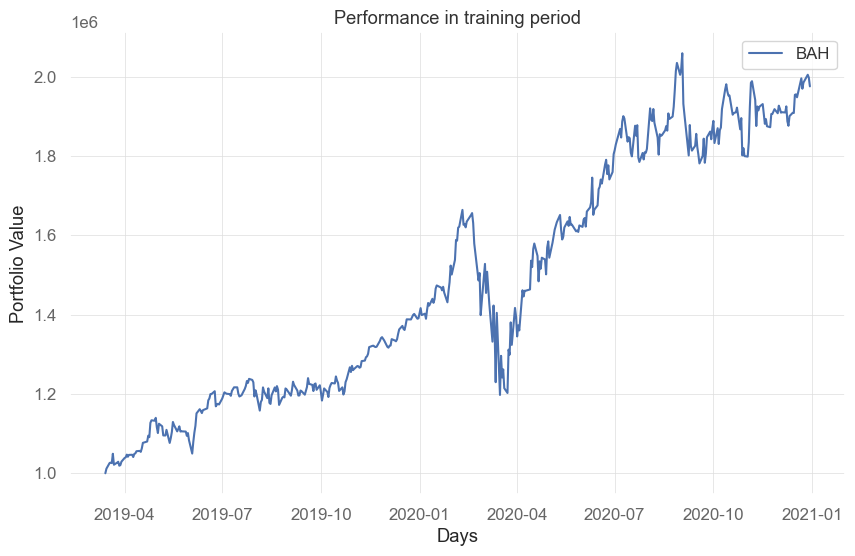

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(BAH_results["date"], BAH_results["training"], label="BAH")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

[*********************100%***********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-03-14  114.540001  115.199997  114.330002  114.589996  108.467926   
2019-03-15  115.339996  117.250000  114.589996  115.910004  109.717415   
2019-03-18  116.169998  117.610001  116.050003  117.570000  111.288742   
2019-03-19  118.089996  118.440002  116.989998  117.650002  111.364471   
2019-03-20  117.389999  118.750000  116.709999  117.519997  111.241409   
...                ...         ...         ...         ...         ...   
2020-12-23  223.110001  223.559998  220.800003  221.020004  213.641907   
2020-12-24  221.419998  223.610001  221.199997  222.750000  215.314163   
2020-12-28  224.449997  226.029999  223.020004  224.960007  217.450424   
2020-12-29  226.309998  227.179993  223.580002  224.149994  216.667435   
2020-12-30  225.229996  225.630005  221.470001  221.679993  214.279907   

              Volume  
Date          

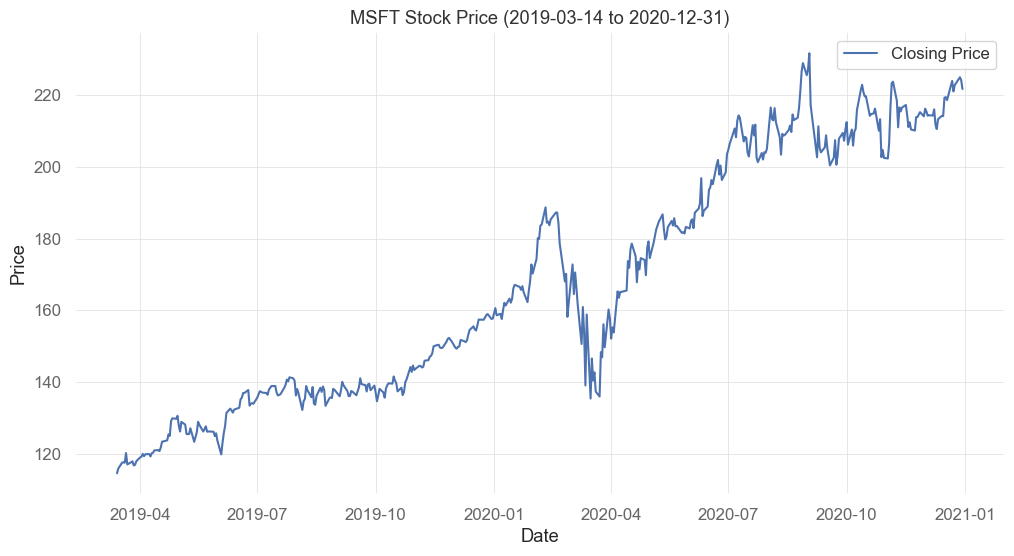

In [101]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

# Define the stock ticker and the time range
ticker = 'MSFT'

# Fetch the stock data
stock_data = yf.download(ticker, start=TRAIN_START_DATE, end=TRAIN_END_DATE)

print(stock_data)


# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price ({TRAIN_START_DATE} to {TRAIN_END_DATE})')
plt.legend()
plt.show()
